In [1]:
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch
import lycon
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# https://pytorch.org/docs/stable/torchvision/models.html
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [126]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.forward = fn

In [127]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval().cuda()
resnet50 = torchvision.models.resnet50(pretrained=True).eval().cuda()
n_dim = resnet50.fc.in_features
resnet50.fc = Lambda(lambda x: x) # replace last layer with identity

In [128]:
image = lambda f, w, h: lycon.resize(lycon.load(f), w, h) / 255

In [129]:
run_maskrcnn = lambda img: {
    k: v.detach().cpu().numpy() if k != 'masks' else \
       v.detach().cpu().numpy().squeeze(1)
    for k, v in maskrcnn(
        [torch.FloatTensor(img).permute(2, 0, 1).cuda()]
    )[0].items()
}

In [130]:
run_resnet50 = lambda img: \
    resnet50(torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0).cuda()).detach().cpu().numpy()[0]

In [131]:
def boxsize(box_output):
    w1, h1, w2, h2 = box_output
    return (w2 - w1) * (h2 - h1)

In [132]:
def display(img, mask, box_output):
    w1, h1, w2, h2 = map(int, box_output)
    img = img[h1:h2, w1:w2]
    mask = mask[h1:h2, w1:w2]
    plt.imshow(img)
    plt.imshow(mask, alpha=0.1)
    plt.show()
    return img, mask

In [230]:
def sample():
    x = image('photo.jpg', 960, 540)
    print('running mask rcnn object detection on this image:')
    plt.imshow(x)
    plt.show()
    with torch.no_grad():
        y = run_maskrcnn(x)
    results = list(zip(y['boxes'], y['labels'], y['scores'], y['masks']))
    # sorting by size small to large & score high to low, combined
    results = sorted(results, key=lambda t: 2 * (1 - t[2]) + np.log(1 + boxsize(t[0])))
    b, l, s, m = results[0]
    #for b, l, s, m in results:
    #print('%s(%.4f)' % (COCO_INSTANCE_CATEGORY_NAMES[l], s))
    img, mask = display(x, m, b)
    return img, mask

running mask rcnn object detection on this image:


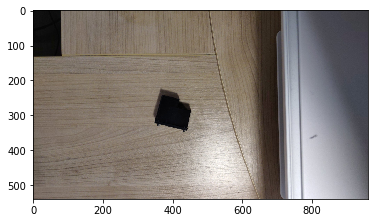

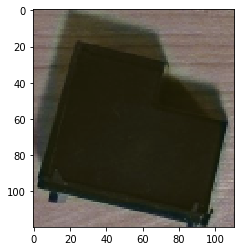

CPU times: user 622 ms, sys: 29.4 ms, total: 651 ms
Wall time: 368 ms


('cartridge', 0.8856695960158699)

In [241]:
%%time
img, mask = sample()
query_vector = run_resnet50(img)
name, score = search_item(query_vector)
name, score

In [229]:
print('correction?')
s = input().strip(' \n')
if s == '':
    add_item(query_vector, name)
else:
    add_item(query_vector, s)

correction?



In [67]:
add_item(query_vector, 'stick')

In [136]:
def cossim(query_vector, item_vectors):
    item_vectors = np.stack(item_vectors, axis=0).astype(np.float)
    item_vectors /= 1e-9 + np.linalg.norm(item_vectors, axis=1, keepdims=1)
    N, D = item_vectors.shape
    query_vector = query_vector.astype(np.float)
    query_vector = query_vector.reshape(D, 1)
    query_vector /= 1e-9 + np.linalg.norm(query_vector)
    return (item_vectors @ query_vector).reshape(N)

In [235]:
#item_vectors = [np.zeros(n_dim)]
#item_names = ['zero']
item_vectors, item_names = torch.load('items.pkl')
def add_item(v, n):
    item_vectors.append(v)
    item_names.append(n)
def search_item(v): # -> name, score
    c = cossim(query_vector, item_vectors)
    # can also use k nearest
    i, s = c.argmax(), c.max()
    return item_names[i], s

In [234]:
torch.save((item_vectors, item_names), 'items.pkl')